### IMPORTING LIBRARIES

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display


import os


### Reading and Utilizing Provided Data


In [2]:
patient_data=pd.read_csv(r'C:\Users\CVA\Desktop\RespiraSense\input\Respiratory_Sound_Database\Respiratory_Sound_Database\patient_diagnosis.csv',names=['pid','disease'])

In [3]:
patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


.Here we have **Patient Ids** and **Disease info**


Lets check out what is in annoted '**.txt**' files of audio files

In [4]:
df=pd.read_csv(r'C:\Users\CVA\Desktop\RespiraSense\input\Respiratory_Sound_Database\Respiratory_Sound_Database\audio_and_txt_files\160_1b3_Al_mc_AKGC417L.txt',sep='\t')
df.head()

,1.862,5.718,0,1
0,5.718,9.725,1,1
1,9.725,13.614,0,1
2,13.614,17.671,0,1
3,17.671,19.541,0,0


These are very usefull information namely (Start , End ( time of respiratory cycles) ,crackles,weezels)

So lets get them into a dataset

In [5]:
import os
path=r'C:\Users\CVA\Desktop\RespiraSense\input\Respiratory_Sound_Database\Respiratory_Sound_Database\audio_and_txt_files'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

['101_1b1_Al_sc_Meditron',
 '101_1b1_Pr_sc_Meditron',
 '102_1b1_Ar_sc_Meditron',
 '103_2b2_Ar_mc_LittC2SE',
 '104_1b1_Al_sc_Litt3200']

As mentioned in **filename_format.txt** , '.txt' files of annotated audio files have various information. So we will try to extract that too.

now we will read multiple text files, extract relevant information from their filenames, add this information as new columns to the data, and combine all the data into a single DataFrame.

In [6]:
def getFilenameInfo(file):
    return file.split('_')

In [7]:
getFilenameInfo('160_1b3_Al_mc_AKGC417L')

['160', '1b3', 'Al', 'mc', 'AKGC417L']

In [8]:
files_data=[]
for file in files:
    data = pd.read_csv(path + '\\' + file + '.txt', sep='\t', names=['start', 'end', 'crackles', 'wheezels'])
    name_data = getFilenameInfo(file)
    data['pid'] = name_data[0]
    data['mode'] = name_data[-2]
    data['filename'] = file
    files_data.append(data)
files_df = pd.concat(files_data)
files_df.reset_index()
files_df.head()


,start,end,crackles,wheezels,pid,mode,filename
0,0.036,0.579,0,0,101,sc,101_1b1_Al_sc_Meditron
1,0.579,2.450,0,0,101,sc,101_1b1_Al_sc_Meditron
2,2.450,3.893,0,0,101,sc,101_1b1_Al_sc_Meditron
3,3.893,5.793,0,0,101,sc,101_1b1_Al_sc_Meditron
4,5.793,7.521,0,0,101,sc,101_1b1_Al_sc_Meditron


In [9]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pid      126 non-null    int64 
 1   disease  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [10]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 10
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   wheezels  6898 non-null   int64  
 4   pid       6898 non-null   object 
 5   mode      6898 non-null   object 
 6   filename  6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


now we will convert the **'pid'** columns in both **patient_data** and **files_df** DataFrames to integers and merge these DataFrames on the 'pid' column

In [11]:
patient_data.pid=patient_data.pid.astype('int32')
files_df.pid=files_df.pid.astype('int32')

In [12]:
data=pd.merge(files_df,patient_data,on='pid')
data.head()

,start,end,crackles,wheezels,pid,mode,filename,disease
0,0.036,0.579,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
1,0.579,2.450,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
2,2.450,3.893,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
3,3.893,5.793,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
4,5.793,7.521,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI


saving the file in csv file

In [13]:
os.makedirs('csv_data')
data.to_csv('csv_data/data.csv',index=False)

## Step 2
## Processing Audio files

we will define a function **getPureSample** to extract a segment of an audio sample based on start and end times, and plot a scatter plot using seaborn to visualize the duration of each audio segment against the patient ID.


we will plot a scatter plot with the duration of each audio segment (data.end - data.start) on the x-axis and the patient ID (data.pid) on the y-axis

In [14]:
def getPureSample(raw_data,start,end,sr=22050):
    '''
    Takes a numpy array and spilts its using start and end args
    
    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo
    
    '''
    max_ind = len(raw_data) 
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

<AxesSubplot:ylabel='pid'>

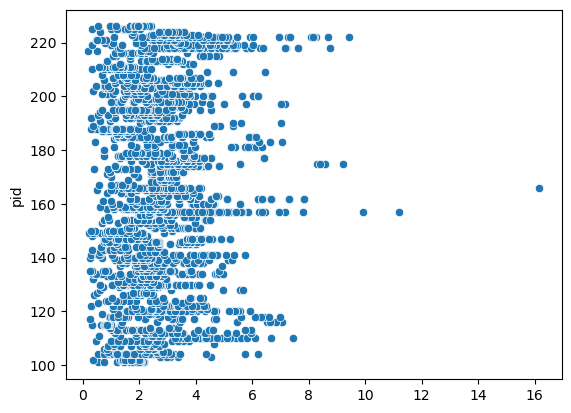

In [15]:
sns.scatterplot(x=(data.end-data.start), y=data.pid)

finding outliers through boxplot

<AxesSubplot:>

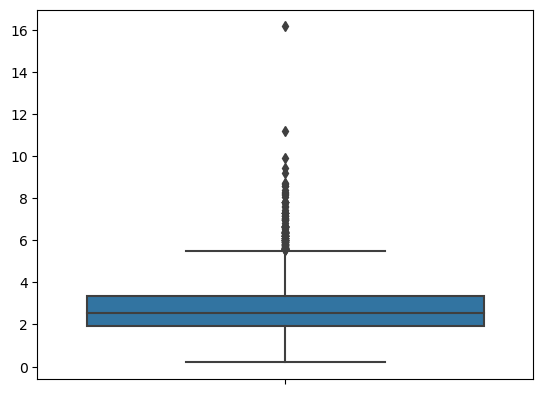

In [16]:
sns.boxplot(y=(data.end-data.start))

From these plots we can conclude that best length is **~6**

Also if difference is <6 we must Zero Pad it to get it to required length

Zero Padding means silent

creating a directory named 'processed_audio_files' and print the index and content of the first row in the data DataFrame for verification.

In [17]:
os.makedirs('processed_audio_files')

In [18]:
for index,row in data.iterrows():
    print("Index ->",index)
    print("Data->\n",row)
    break

Index -> 0
Data->
 start                        0.036
end                          0.579
crackles                         0
wheezels                         0
pid                            101
mode                            sc
filename    101_1b1_Al_sc_Meditron
disease                       URTI
Name: 0, dtype: object


 now we will iterate through each row in the data DataFrame, process audio files by trimming or padding them to a maximum length of **6sec**, and save the processed audio files to the **'processed_audio_files'** directory, updating the filenames if multiple cycles exist for the same patient

In [19]:
import os
import librosa as lb
import soundfile as sf

# Ensure the output directory exists
if not os.path.exists('processed_audio_files'):
    os.makedirs('processed_audio_files')

i, c = 0, 0
for index, row in data.iterrows():
    maxLen = 6
    start = row['start']
    end = row['end']
    filename = row['filename']
    
    # If len > maxLen, change it to maxLen
    if end - start > maxLen:
        end = start + maxLen
    
    audio_file_loc = os.path.join(path, filename + '.wav')
    
    if index > 0:
        # Check if more cycles exist for the same patient, if so then add i to change filename
        if data.iloc[index - 1]['filename'] == filename:
            i += 1
        else:
            i = 0
    filename = filename + '_' + str(i) + '.wav'
    
    save_path = os.path.join('processed_audio_files', filename)
    c += 1
    
    try:
        # Load audio file
        audioArr, sampleRate = lb.load(audio_file_loc)
        pureSample = getPureSample(audioArr, start, end, sampleRate)
        
        # Pad audio if pureSample len < max_len
        reqLen = 6 * sampleRate
        padded_data = lb.util.pad_center(pureSample, size=reqLen)
        
        # Ensure padded_data is in float32 format
        padded_data = padded_data.astype('float32')
        
        # Write audio file
        sf.write(file=save_path, data=padded_data, samplerate=sampleRate)
    
    except Exception as e:
        print(f"Error processing file {filename}: {e}")

print('Total Files Processed:', c)


Total Files Processed: 6898


In [20]:
import librosa as lb

In [21]:
diagnosis=pd.read_csv(r'C:\Users\CVA\Desktop\RespiraSense\input\Respiratory_Sound_Database\Respiratory_Sound_Database\patient_diagnosis.csv',names=['pid','disease'])
diagnosis.head()


,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In the following plot we can see that classes are imbalanced so we must split them into train and validation set via stratify

E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'URTI'),
  Text(1, 0, 'Healthy'),
  Text(2, 0, 'Asthma'),
  Text(3, 0, 'COPD'),
  Text(4, 0, 'LRTI'),
  Text(5, 0, 'Bronchiectasis'),
  Text(6, 0, 'Pneumonia'),
  Text(7, 0, 'Bronchiolitis')])

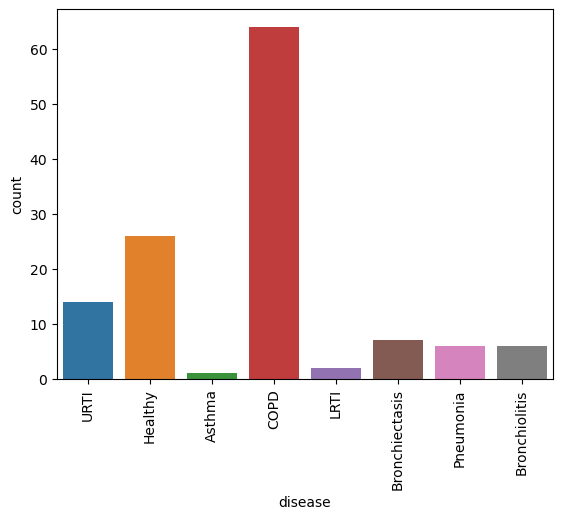

In [22]:
sns.countplot(diagnosis.disease)
plt.xticks(rotation=90)

We will try to extract Id of each processed audio file and then merge them with their respective class label so we can split files in to train and validation folder in stratified manner

In [23]:
import os
def extractId(filename):
    return filename.split('_')[0]

In [24]:
path=r'C:\Users\CVA\Desktop\RespiraSense\processed_audio_files/'
length=len(os.listdir(path))
index=range(length)
i=0
files_df=pd.DataFrame(index=index,columns=['pid','filename'])
for f in os.listdir(path):
    files_df.iloc[i]['pid']=extractId(f)
    files_df.iloc[i]['filename']=f
    i+=1
files_df.head()

,pid,filename
0,101,101_1b1_Al_sc_Meditron_0.wav
1,101,101_1b1_Al_sc_Meditron_1.wav
2,101,101_1b1_Al_sc_Meditron_10.wav
3,101,101_1b1_Al_sc_Meditron_11.wav
4,101,101_1b1_Al_sc_Meditron_2.wav


In [25]:
files_df.pid=files_df.pid.astype('int64') # both pid's must be of same dtype for them to merge

In [26]:
data=pd.merge(files_df,diagnosis,on='pid')
data.head()

,pid,filename,disease
0,101,101_1b1_Al_sc_Meditron_0.wav,URTI
1,101,101_1b1_Al_sc_Meditron_1.wav,URTI
2,101,101_1b1_Al_sc_Meditron_10.wav,URTI
3,101,101_1b1_Al_sc_Meditron_11.wav,URTI
4,101,101_1b1_Al_sc_Meditron_2.wav,URTI


E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'URTI'),
  Text(1, 0, 'Healthy'),
  Text(2, 0, 'Asthma'),
  Text(3, 0, 'COPD'),
  Text(4, 0, 'LRTI'),
  Text(5, 0, 'Bronchiectasis'),
  Text(6, 0, 'Pneumonia'),
  Text(7, 0, 'Bronchiolitis')])

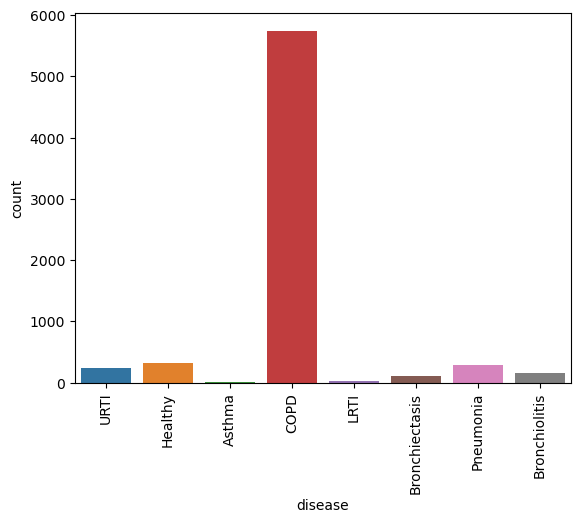

In [27]:
sns.countplot(data.disease)
plt.xticks(rotation=90)

splitting the data DataFrame into training and validation sets with stratification based on the 'disease' column to maintain the class distribution in both sets

In [28]:
from sklearn.model_selection import train_test_split
Xtrain,Xval,ytrain,yval=train_test_split(data,data.disease,stratify=data.disease,random_state=42,test_size=0.25)

In [29]:
Xtrain.disease.value_counts()/Xtrain.shape[0]

COPD              0.832979
Healthy           0.046588
Pneumonia         0.041369
URTI              0.035183
Bronchiolitis     0.023197
Bronchiectasis    0.015078
LRTI              0.004639
Asthma            0.000967
Name: disease, dtype: float64

In [30]:
Xval.disease.value_counts()/Xval.shape[0]

COPD              0.833043
Healthy           0.046957
Pneumonia         0.041159
URTI              0.035362
Bronchiolitis     0.023188
Bronchiectasis    0.015072
LRTI              0.004638
Asthma            0.000580
Name: disease, dtype: float64

We did this because this will help our model to learn and validate classes , it will not be like we are training only on COPD disease and there is no COPD in our validation

### Visualizing MFCCS(Mel-Frequency Cepstral Coefficients) for analyzing the audio's frequency content over time.

[Text(0.5, 1.0, 'MFCC')]

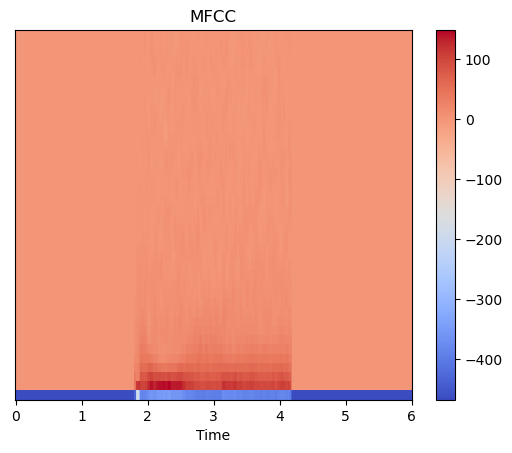

In [31]:


import librosa.display
file=path + Xtrain.iloc[193].filename 
sound,sample_rate=lb.load(file)
mfccs = lb.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40)
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

Here I am going to output train & test datasets so that i can use the filenames in then in another notebook where i will try other feature extraction methods inclusive of MFCC's and adopt the one or many based on performance.

In [32]:
Xtrain.to_csv('train.csv')
Xval.to_csv('val.csv')

In [33]:
import librosa.display as lbd

In [34]:
train=pd.read_csv(r'C:\Users\CVA\Desktop\RespiraSense\train.csv')
val=pd.read_csv(r'C:\Users\CVA\Desktop\RespiraSense\val.csv')
train.head()

,Unnamed: 0,pid,filename,disease
0,1650,133,133_2p4_Pr_mc_AKGC417L_0.wav,COPD
1,2672,152,152_1b1_Al_sc_Meditron_6.wav,Healthy
2,548,112,112_1p1_Pr_sc_Litt3200_8.wav,COPD
3,4733,179,179_1b1_Al_sc_Meditron_6.wav,Healthy
4,1438,130,130_3p2_Ar_mc_AKGC417L_6.wav,COPD


In [35]:
ytrain=train.disease
yval=val.disease
yval

0       COPD
1       COPD
2       COPD
3       COPD
4       COPD
        ... 
1720    COPD
1721    COPD
1722    COPD
1723    COPD
1724    COPD
Name: disease, Length: 1725, dtype: object

As our class labels are of **dtype:** object we must first convert them to encoded values or intergers

In [36]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
ytrain=le.fit_transform(ytrain)
yval=le.transform(yval)

#### Feature Extraction

I am going to use Librosa's feature extraction methods here


In [37]:
def getFeatures(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec

In These functions i m iterating over **train** and **val** dataset, and using filenames to extract features and then converting them to numpy arrays

In [38]:
root=r'C:\Users\CVA\Desktop\RespiraSense\processed_audio_files'
mfcc,cstft,mSpec=[],[],[]

for idx,row in val.iterrows():
    path=root +'\\'+ row['filename']
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    
mfcc_val=np.array(mfcc)
cstft_val=np.array(cstft)
mSpec_val=np.array(mSpec)

E:\Anaconda\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [39]:
import numpy as np
import pandas as pd
import librosa as lb
import soundfile as sf

def getFeatures(path):
    # Load the audio file
    y, sr = lb.load(path)
    
    # Extract features
    mfcc = lb.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    cstft = lb.feature.chroma_stft(y=y, sr=sr)
    mSpec = lb.feature.melspectrogram(y=y, sr=sr)
    tone = lb.feature.tonnetz(y=y, sr=sr)  # This will be discarded
    specCen = lb.feature.spectral_centroid(y=y, sr=sr)  # This will be discarded
    
    return mfcc, cstft, mSpec, tone, specCen

# Path to the processed audio files
root = r'C:\Users\CVA\Desktop\RespiraSense\processed_audio_files'

# Initialize lists for storing features
mfcc_train, cstft_train, mSpec_train = [], [], []
mfcc_val, cstft_val, mSpec_val = [], [], []

# Assuming 'train' and 'val' are DataFrames with a column 'filename'
# If 'train' and 'val' are not defined, you need to load your DataFrames here
# train = pd.read_csv('path_to_train.csv')
# val = pd.read_csv('path_to_val.csv')

# Process the training data
for idx, row in train.iterrows():
    path = root +'\\'+ row['filename']
    
    # Extract only the necessary features
    a, b, c, _, _ = getFeatures(path)
    mfcc_train.append(a)
    cstft_train.append(b)
    mSpec_train.append(c)
    
# Convert lists to numpy arrays
mfcc_train = np.array(mfcc_train)
cstft_train = np.array(cstft_train)
mSpec_train = np.array(mSpec_train)

# Process the validation data
for idx, row in val.iterrows():
    path = root + '\\'+ row['filename']
    
    # Extract only the necessary features
    a, b, c, _, _ = getFeatures(path)
    mfcc_val.append(a)
    cstft_val.append(b)
    mSpec_val.append(c)
    
# Convert lists to numpy arrays
mfcc_val = np.array(mfcc_val)
cstft_val = np.array(cstft_val)
mSpec_val = np.array(mSpec_val)

# Print shapes to verify
print('MFCC train shape:', mfcc_train.shape)
print('CSTFT train shape:', cstft_train.shape)
print('MSpec train shape:', mSpec_train.shape)

print('MFCC val shape:', mfcc_val.shape)
print('CSTFT val shape:', cstft_val.shape)
print('MSpec val shape:', mSpec_val.shape)


MFCC train shape: (5173, 20, 259)
CSTFT train shape: (5173, 12, 259)
MSpec train shape: (5173, 128, 259)
MFCC val shape: (1725, 20, 259)
CSTFT val shape: (1725, 12, 259)
MSpec val shape: (1725, 128, 259)


The **shape** of features returned by the above function **(20, 259) (12, 259) (128, 259)** we need this for defining input shape of our model and **Discarded** few features beacuse they were not important to performance

### Testing Features

Lets create model using Keras Functional API to check how the features perform.

In [40]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]

Here i m creating three different **CNN** and then Combining them to a Dense Network.

In [41]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")

In [42]:
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mfccInput (InputLayer)      [(None, 20, 259, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 87, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 20, 87, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 87, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 43, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 22, 64)        18

In [43]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")

In [44]:
croma_model.summary()

Model: "cromaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cromaInput (InputLayer)     [(None, 12, 259, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 87, 32)        832       
                                                                 
 batch_normalization_4 (Batc  (None, 12, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 12, 87, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 43, 32)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 22, 64)         1

In [45]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")

In [46]:
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mSpecInput (InputLayer)     [(None, 128, 259, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 87, 32)        832       
                                                                 
 batch_normalization_7 (Batc  (None, 64, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 64, 87, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 22, 64)        1

In [47]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(8,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")

In [48]:
net.summary()

Model: "Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 croma (InputLayer)             [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 mspec (InputLayer)             [(None, 128, 259, 1  0           []                               
                                )]                                                              

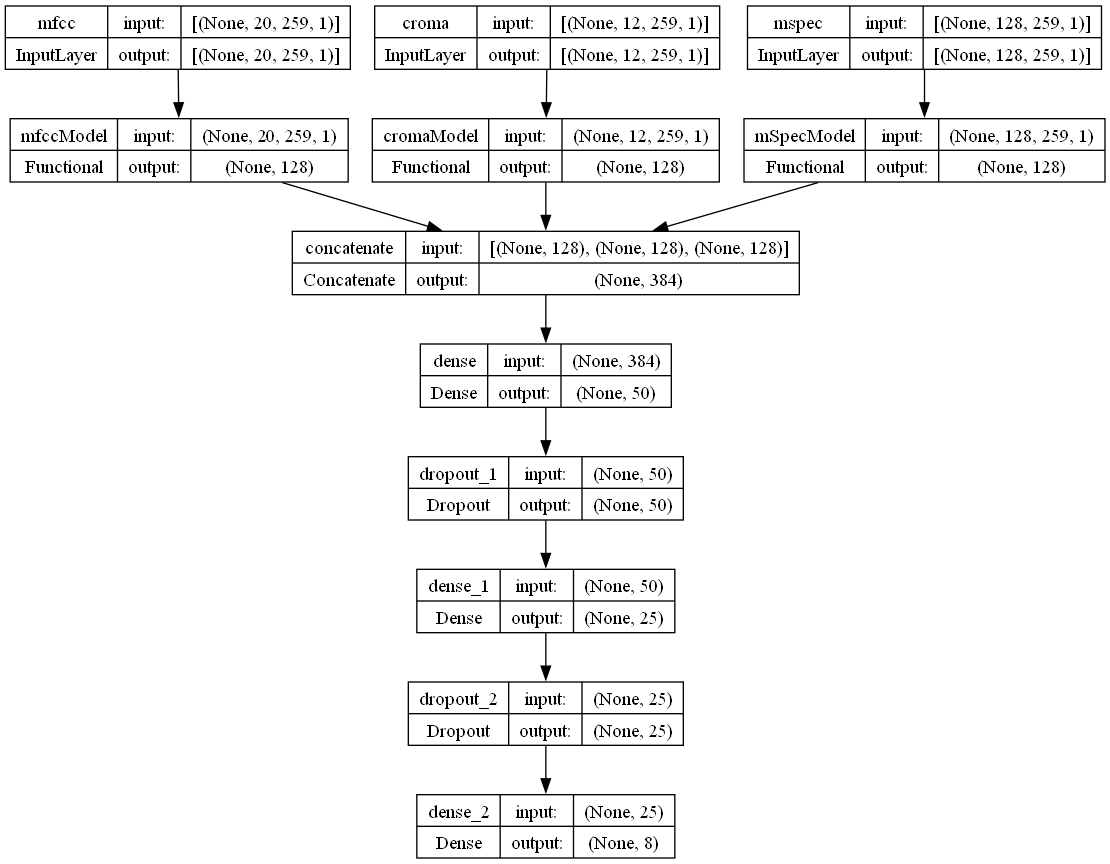

In [49]:
keras.utils.plot_model(net, "net.png", show_shapes=True)

In [50]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [51]:
history=net.fit(
    {"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train},
    ytrain,
    validation_data=({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval),
    epochs=50,verbose=1,
    callbacks=my_callbacks
)

Epoch 1/50
162/162 [==============================] - 59s 311ms/step - loss: 0.7453 - accuracy: 0.7848 - val_loss: 0.9144 - val_accuracy: 0.7455 - lr: 0.0010
Epoch 2/50
162/162 [==============================] - 50s 311ms/step - loss: 0.5024 - accuracy: 0.8336 - val_loss: 0.4945 - val_accuracy: 0.8417 - lr: 0.0010
Epoch 3/50
162/162 [==============================] - 55s 343ms/step - loss: 0.4407 - accuracy: 0.8454 - val_loss: 0.5694 - val_accuracy: 0.8307 - lr: 0.0010
Epoch 4/50
162/162 [==============================] - 51s 317ms/step - loss: 0.4143 - accuracy: 0.8540 - val_loss: 0.3539 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 5/50
162/162 [==============================] - 52s 323ms/step - loss: 0.3697 - accuracy: 0.8631 - val_loss: 0.5763 - val_accuracy: 0.7948 - lr: 0.0010
Epoch 6/50
162/162 [==============================] - 51s 317ms/step - loss: 0.3536 - accuracy: 0.8672 - val_loss: 0.3828 - val_accuracy: 0.8614 - lr: 0.0010
Epoch 7/50
162/162 [==============================] 

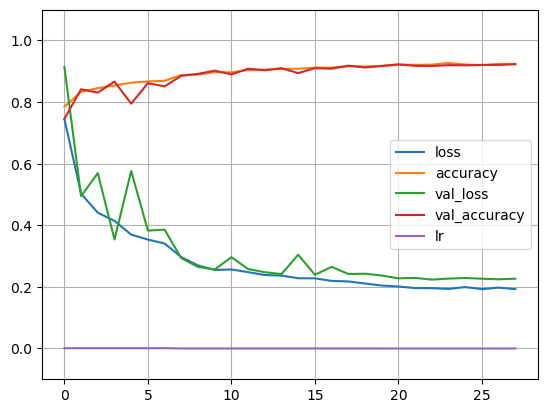

In [52]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

In [53]:
net.evaluate({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval)

54/54 [==============================] - 4s 73ms/step - loss: 0.2266 - accuracy: 0.9229


[0.2265675812959671, 0.922898530960083]

In [54]:
import numpy as np
import librosa

# Expected input shape
EXPECTED_SHAPE = (20, 259, 1)

# Function to extract features from an audio file
def get_features(audio_path, expected_shape):
    y, sr = librosa.load(audio_path, sr=None)
    
    # Extract features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=expected_shape[0])
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    
    # Ensure that all features have the same length
    min_length = min(mfcc.shape[1], chroma_stft.shape[1], mel_spectrogram.shape[1])
    mfcc = mfcc[:, :min_length]
    chroma_stft = chroma_stft[:, :min_length]
    mel_spectrogram = mel_spectrogram[:, :min_length]
    
    # Pad or truncate features to match the expected shape
    def pad_or_truncate(feature, expected_length):
        if feature.shape[1] < expected_length:
            padding = expected_length - feature.shape[1]
            feature = np.pad(feature, ((0, 0), (0, padding)), mode='constant')
        else:
            feature = feature[:, :expected_length]
        return feature
    
    mfcc = pad_or_truncate(mfcc, expected_shape[1])
    chroma_stft = pad_or_truncate(chroma_stft, expected_shape[1])
    mel_spectrogram = pad_or_truncate(mel_spectrogram, expected_shape[1])
    
    # Reshape features to match the input shape expected by the model
    mfcc = mfcc[np.newaxis, ..., np.newaxis]
    chroma_stft = chroma_stft[np.newaxis, ..., np.newaxis]
    mel_spectrogram = mel_spectrogram[np.newaxis, ..., np.newaxis]
    
    return mfcc, chroma_stft, mel_spectrogram

# Function to predict the disease from an audio file
def predict_disease(audio_path, model, expected_shape):
    # Extract features
    mfcc, chroma_stft, mel_spectrogram = get_features(audio_path, expected_shape)
    
    # Make a prediction
    prediction = model.predict({"mfcc": mfcc, "croma": chroma_stft, "mspec": mel_spectrogram})
    
    # Get the predicted class
    predicted_class = np.argmax(prediction, axis=1)[0]
    
    return predicted_class

# Dictionary to map class indices to disease names
class_names = {
    0: "COPD",
    1: "Healthy",
    2: "Pneumonia",
    3: "URTI",
    4: "Bronchiolitis",
    5: "Bronchiectasis",
    6: "LRTI",
    7: "Asthma"
}


disease_symptoms = {
    "Asthma": "Wheezes",
    "COPD": "Wheezes",
    "Pneumonia": "Crackles",
    "Bronchiolitis": "Crackles",
    "Bronchiectasis": "Crackles",
    "LRTI": "Crackles",
    "Healthy": "Normal",
    "URTI": "Normal"  # Assuming URTI is not associated with specific sounds
}


audio_path = r'C:\Users\CVA\Desktop\RespiraSense\Dataset\data\test\126_1b1_Al_sc_Meditron.wav'
predicted_class = predict_disease(audio_path, net, EXPECTED_SHAPE)
predicted_disease = class_names[predicted_class]


symptom = disease_symptoms.get(predicted_disease, "Unknown")

print(f"The predicted disease for the given audio file is: {predicted_disease}")
print(f"The associated symptom is: {symptom}")


1/1 [==============================] - 0s 308ms/step
The predicted disease for the given audio file is: Asthma
The associated symptom is: Wheezes


# LSTM + CNN HYBRID ALGORITHM

#### I replaces the CNN architecture with a hybrid CNN-LSTM model for feature extraction and classification. We'll use LSTM layers to capture temporal dependencies in the extracted features.

In [63]:
import numpy as np
import pandas as pd
import librosa as lb
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, callbacks, optimizers
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, concatenate
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Encoding class labels
le = LabelEncoder()
ytrain = le.fit_transform(ytrain)
yval = le.transform(yval)

# Load and preprocess the data
def getFeatures(path):
    y, sr = lb.load(path)
    mfcc = lb.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    cstft = lb.feature.chroma_stft(y=y, sr=sr)
    mSpec = lb.feature.melspectrogram(y=y, sr=sr)
    return mfcc, cstft, mSpec

root = r'C:\Users\CVA\Desktop\RespiraSense\processed_audio_files'
mfcc_train, cstft_train, mSpec_train = [], [], []
mfcc_val, cstft_val, mSpec_val = [], [], []

# Assuming 'train' and 'val' are DataFrames with a column 'filename'
for idx, row in train.iterrows():
    path = root + '\\' + row['filename']
    a, b, c = getFeatures(path)
    mfcc_train.append(a)
    cstft_train.append(b)
    mSpec_train.append(c)

for idx, row in val.iterrows():
    path = root + '\\' + row['filename']
    a, b, c = getFeatures(path)
    mfcc_val.append(a)
    cstft_val.append(b)
    mSpec_val.append(c)

# Convert lists to numpy arrays
mfcc_train = np.array(mfcc_train)
cstft_train = np.array(cstft_train)
mSpec_train = np.array(mSpec_train)
mfcc_val = np.array(mfcc_val)
cstft_val = np.array(cstft_val)
mSpec_val = np.array(mSpec_val)

# Define LSTM-based models
input_mfcc = Input(shape=(None, 20), name="mfcc")
mfcc = LSTM(128, return_sequences=True)(input_mfcc)
mfcc = Dropout(0.3)(mfcc)
mfcc = LSTM(64)(mfcc)
mfcc = Dropout(0.3)(mfcc)

input_croma = Input(shape=(None, 12), name="croma")
croma = LSTM(128, return_sequences=True)(input_croma)
croma = Dropout(0.3)(croma)
croma = LSTM(64)(croma)
croma = Dropout(0.3)(croma)

input_mSpec = Input(shape=(None, 128), name="mspec")
mSpec = LSTM(128, return_sequences=True)(input_mSpec)
mSpec = Dropout(0.3)(mSpec)
mSpec = LSTM(64)(mSpec)
mSpec = Dropout(0.3)(mSpec)

# Concatenate all features
concat = concatenate([mfcc, croma, mSpec])
hidden = Dropout(0.3)(concat)
hidden = Dense(50, activation='relu')(hidden)
hidden = Dropout(0.3)(hidden)
hidden = Dense(25, activation='relu')(hidden)
hidden = Dropout(0.3)(hidden)
output = Dense(8, activation='softmax')(hidden)

# Define the model
net = Model(inputs=[input_mfcc, input_croma, input_mSpec], outputs=output, name="Net")

# Compile the model
net.compile(loss='sparse_categorical_crossentropy', optimizer=Nadam(learning_rate=0.001), metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Train the model
history = net.fit(
    {"mfcc": mfcc_train, "croma": cstft_train, "mspec": mSpec_train},
    ytrain,
    validation_data=({"mfcc": mfcc_val, "croma": cstft_val, "mspec": mSpec_val}, yval),
    epochs=50, verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)
